In [ ]:
pip install sklearn matplotlib

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post11-py3-none-any.whl size=2959 sha256=d3fdc9f0684ce320c0f3969838d541e46e3fd74e12ebc41ef05b36763b08a83e
  Stored in directory: /root/.cache/pip/wheels/aa/9c/60/f67813603a52fc35057868f1aba0003cc75b72583dcaa2c341
Successfully built sklearn


In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.2 MB/s eta 0:00:00


In [ ]:
import os
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT")

In [ ]:
def get_model_prediction(text):
    tokenized_inputs = tokenizer(text, truncation=True, return_tensors='pt', max_length=512)
    inputs = {'input_ids': tokenized_inputs['input_ids'], 'attention_mask': tokenized_inputs['attention_mask']}
    outputs = model(**inputs)
    logits = outputs[0]
    probs = logits.softmax(dim=-1)[0].tolist()

    stance_mapping = {0: "left", 1: "center", 2: "right"}
    predicted_stance = stance_mapping[probs.index(max(probs))]

    return predicted_stance

In [6]:
# Load the filtered speeches and metadata
file_path = 'filtered_metadata_with_party.csv'
df = pd.read_csv(file_path)

In [7]:
df.isnull().sum()

speech_id     0
chamber       0
date          0
speaker       0
first_name    0
last_name     0
state         0
gender        0
char_count    0
word_count    0
party         0
speech        0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df['party'].value_counts()

D    5296
R    2707
I     160
P       1
Name: party, dtype: int64

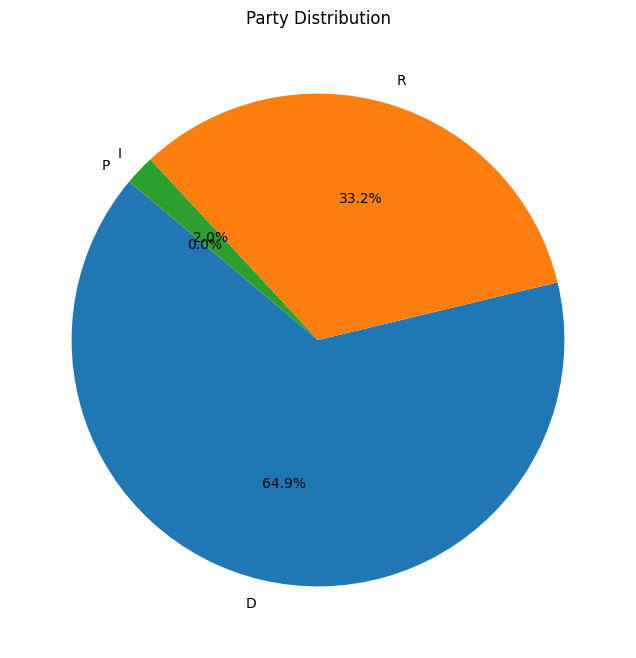

In [10]:
# Count the frequency of each party
party_counts = df['party'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(party_counts, labels=party_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Party Distribution')
plt.show()

Removing parties "I" and "P"

In [11]:
df = df[df['party'].isin(['D', 'R'])]

D    5296
R    2707
Name: party, dtype: int64


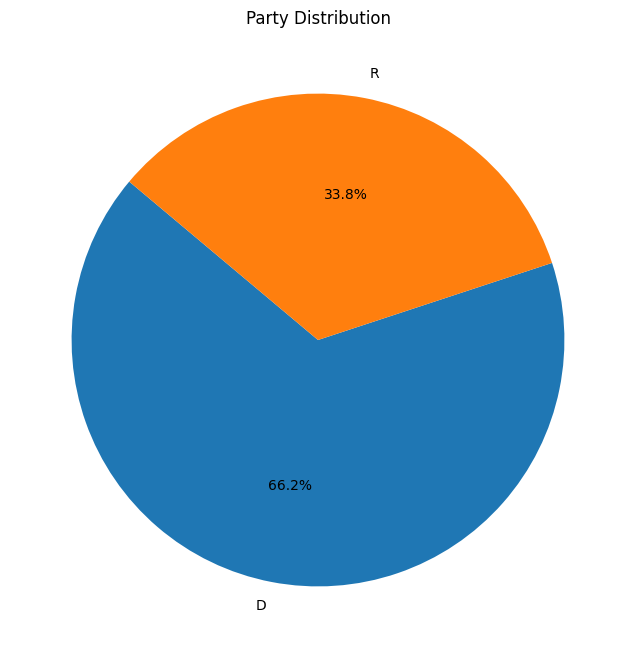

In [12]:
# Count the frequency of each party
party_counts = df['party'].value_counts()
print(party_counts)

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(party_counts, labels=party_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Party Distribution')
plt.show()

In [ ]:
df_100 = df[0:100]

In [13]:
true_labels = df['party'].tolist()
predicted_labels = []

In [14]:
for text in tqdm(df['speech'], position=0):
    predicted_labels.append(get_model_prediction(text))

100%|██████████| 8003/8003 [4:05:29<00:00,  1.84s/it]


In [15]:

df_labels = pd.DataFrame(predicted_labels, columns=['PredictedLabel'])

# Save to CSV
csv_file_path = 'predicted_labels.csv'
df_labels.to_csv(csv_file_path, index=False)

print(f"File saved as {csv_file_path}")

File saved as predicted_labels.csv


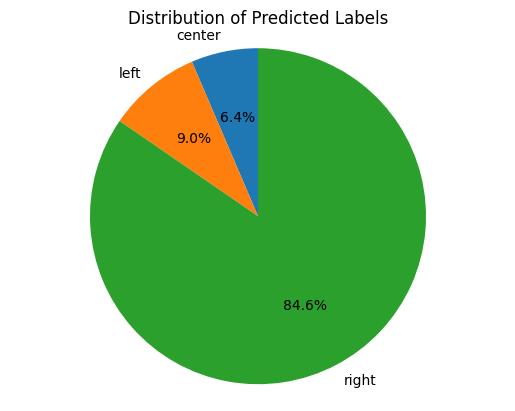

In [21]:
# Create a pie chart for predicted labels
label_counts = {label: predicted_labels.count(label) for label in set(predicted_labels)}
labels = label_counts.keys()
sizes = label_counts.values()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Distribution of Predicted Labels")
plt.show()

In [16]:
# Transformation dictionary
transformation = {"D": "left", "R": "right"}

Accuracy: 0.3698
              precision    recall  f1-score   support

        left       0.64      0.09      0.16      4925
       right       0.34      0.90      0.49      2563

    accuracy                           0.37      7488
   macro avg       0.49      0.50      0.33      7488
weighted avg       0.54      0.37      0.28      7488



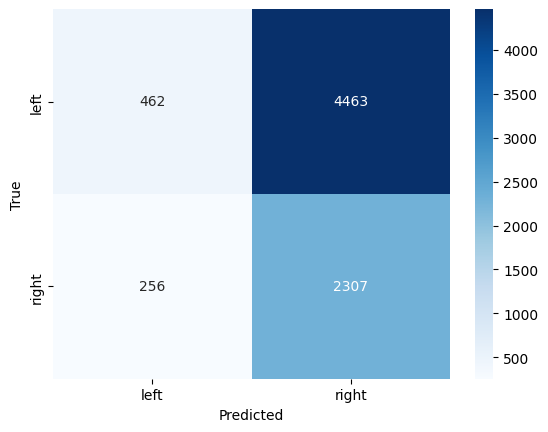

In [20]:
import seaborn as sns
# Transform the true labels
transformed_true_labels = [transformation.get(label) for label in true_labels]

# Filter out 'center' predictions for direct comparison
filtered_indices = [i for i, label in enumerate(predicted_labels) if label != 'center']
filtered_true_labels = [transformed_true_labels[i] for i in filtered_indices]
filtered_predicted_labels = [predicted_labels[i] for i in filtered_indices]

# Accuracy and Classification Report
accuracy = accuracy_score(filtered_true_labels, filtered_predicted_labels)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(filtered_true_labels, filtered_predicted_labels))

# Confusion Matrix
cm = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=["left", "right"])
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["left", "right"], yticklabels=["left", "right"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()